In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import gtfparse


intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])

long_table['gene'] = [x.split('.')[0] for x in long_table.gene]

del intron_annot
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

expressed_genes.gene = [x.split('.')[0] for x in expressed_genes.gene]

In [2]:
long_table = long_table.loc[long_table.Dataset == 'chRNA.Expression.Splicing']

gene_total = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.sum()).reset_index()
gene_total.columns = ['gene', 'IndID', 'gene_total']

gene_max = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.max()).reset_index()
gene_max.columns = ['gene', 'IndID', 'gene_max']

long_table = long_table.merge(gene_total, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']).merge(
    gene_max, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']
)

long_table['PSI_total'] = long_table.Count/long_table.gene_total
long_table['PSI'] = long_table.Count/long_table.gene_max


In [3]:
long_table = long_table.loc[long_table.gene.isin(expressed_genes.gene)]

NMD = ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
PC = ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']



In [4]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
RPKM.index = [x.split('.')[0] for x in RPKM.index]

log2RPKM = RPKM[RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2RPKM.columns = ['gene', 'RPKM']

In [5]:
nmd_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum())

idx = nmd_counts.index

pc_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(PC)].groupby('gene').Count.sum()).reindex(idx).fillna(0)


psi = (nmd_counts.Count/(pc_counts.Count + nmd_counts.Count))

In [6]:
exon_counts = pd.read_csv('../code/exons.appris_principal.basic_annotation.bed.gz', sep='\t')
exon_counts.columns = ['chrom', 'start', 'end', 'gene', 'symbol', 'strand', 'transcript']
exon_counts.gene = [x.split('.')[0] for x in exon_counts.gene]
exon_counts['exon_count'] = 1

In [7]:
from scipy.stats import entropy

long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
long_summary = long_summary.merge(pd.DataFrame(
    exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []
entropy_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
    intron_counts = list(df.exon_count)[0]
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    entropy_ = entropy(rank_percent)
    entropy_list.append(entropy_)
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list, entropy_list]).T
df_summary.columns = ['total_reads', 'total_junctions', 'entropy']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11563/11563 [00:07<00:00, 1453.21it/s]


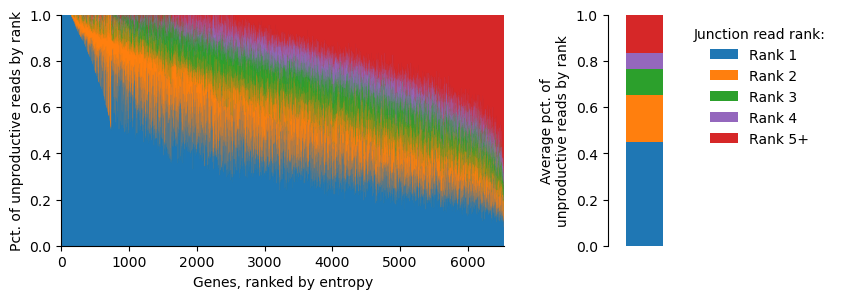

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), gridspec_kw={'width_ratios': [6, 1], 
                                                                       'wspace': 0.4})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.01)].index

top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()

df_idx = rank_.index

i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


for idx, row in df_rank_.loc[entropy_idx].iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes, ranked by entropy')
ax[0].set_ylabel('Pct. of unproductive reads by rank')

ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, i])
ax[1].set_ylim([0, 1])


# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].set_ylabel('Average pct. of\nunproductive reads by rank')

ax[1].set_xticks([])
ax[1].legend(bbox_to_anchor=(1, 1), frameon=False, title = 'Junction read rank:')

fig_dir = '/project2/yangili1/carlos_and_ben_shared/manuscript_plots/'

plt.savefig(fig_dir + 'Read_ranks.100reads_1_to_20_percent_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Read_ranks.100reads_1_to_20_percent_NMD.png', dpi=300, bbox_inches='tight',)

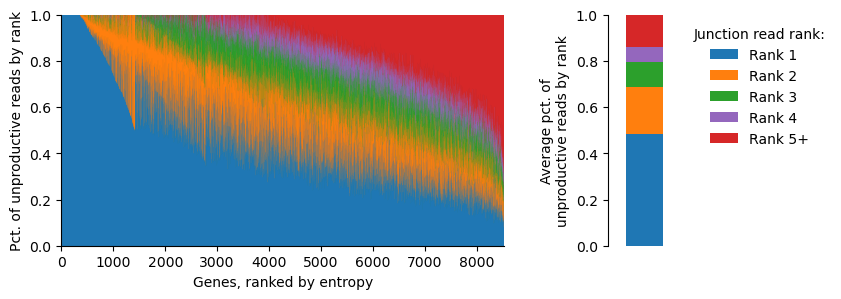

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), gridspec_kw={'width_ratios': [6, 1], 
                                                                       'wspace': 0.4})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.001)].index

top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()

df_idx = rank_.index

i = 0

df_rank_ = df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


for idx, row in df_rank_.loc[entropy_idx].iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes, ranked by entropy')
ax[0].set_ylabel('Pct. of unproductive reads by rank')

ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, i])
ax[1].set_ylim([0, 1])


# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].set_ylabel('Average pct. of\nunproductive reads by rank')

ax[1].set_xticks([])
ax[1].legend(bbox_to_anchor=(1, 1), frameon=False, title = 'Junction read rank:')

plt.savefig(fig_dir + 'Read_ranks.100reads_0.1_to_20_percent_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Read_ranks.100reads_0.1_to_20_percent_NMD.png', dpi=300, bbox_inches='tight',)

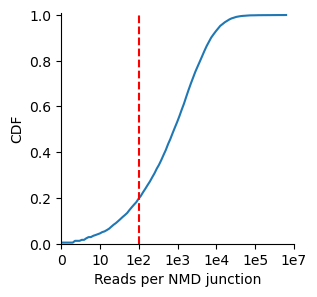

In [32]:
fig, ax = plt.subplots(figsize=(3, 3))

x = np.linspace(np.log10(long_summary.groupby('gene').Count.sum()).min(), 
                np.log10(long_summary.groupby('gene').Count.sum()).max(), 100)
y = [(np.log10(long_summary.groupby('gene').Count.sum()) <= z).mean() for z in x]
ax.plot(x, y)
ax.set_xlabel('Reads per NMD junction')
ax.set_ylabel('CDF')
# plt.xlim([-1, 51])
ax.set_xticks(range(7), ['0', '10', '1e2', '1e3', '1e4', '1e5', '1e7'])
ax.plot([2, 2], [0, 1], 'r--')
ax.set_xlim([0, 6])
ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.png', dpi=300, bbox_inches='tight',)

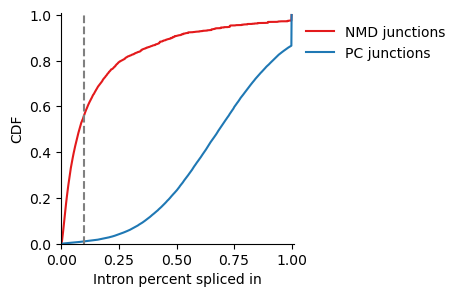

In [29]:
long_table_sum = long_table.groupby(['gene', 'symbol', 'junction', 'NewAnnotation', 'SuperAnnotation']
                                   ).Count.sum().reset_index()

gene_total_sum = pd.DataFrame(long_table_sum.groupby(['gene']).Count.max()).reset_index()
gene_total_sum.columns = ['gene',  'gene_max']

long_table_sum = long_table_sum.merge(gene_total_sum, left_on='gene', right_on='gene')
long_table_sum['PSI'] = long_table_sum.Count/long_table_sum.gene_max

long_table_sum_NMD = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)]
long_table_sum_PC = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(PC)]
x = np.linspace(0, 1, 1001)
contribution_NMD = [long_table_sum_NMD.loc[long_table_sum_NMD.PSI <= y].Count.sum() for y in x]
contribution_PC = [long_table_sum_PC.loc[long_table_sum_PC.PSI <= y].Count.sum() for y in x]

fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(x, np.array(contribution_NMD)/np.max(contribution_NMD), label='NMD junctions', c='#e31a1c')
ax.plot(x, np.array(contribution_PC)/np.max(contribution_PC), label='PC junctions', c='#1f78b4')
ax.plot([0.1, 0.1], [0, 100], linestyle='--', c='gray')
ax.set_xlabel('Intron percent spliced in')
ax.set_ylabel('CDF')
ax.legend(frameon=False, bbox_to_anchor=(1, 1))

ax.set_xlim([0, 1.01])
ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.png', dpi=300, bbox_inches='tight',)